Importing Dependies


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt

In [2]:
#import the CSV files (https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather)
energy = pd.read_csv("energy_dataset.csv")
energy.head()


,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [3]:
weather=pd.read_csv("weather_features.csv")
weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


# Data Cleaning

In [4]:
# Convert time to datetime object in energy data set and set it as index
energy['time'] = pd.to_datetime(energy['time'], utc=True, infer_datetime_format=True)
energy = energy.set_index('time')
energy.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [5]:
# Finding duplicates and null values in energy data set
print('There are {} missing values or NaNs in energy.'
      .format(energy.isnull().values.sum()))

temp_energy = energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in energy based on all columns.'
      .format(temp_energy))

There are 70529 missing values or NaNs in energy.
There are 0 duplicate rows in energy based on all columns.


In [6]:
energy[energy.isnull().any(axis=1)].tail()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,,
2018-12-31 18:00:00+00:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,NaN,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
2018-12-31 19:00:00+00:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,NaN,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
2018-12-31 20:00:00+00:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,NaN,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
2018-12-31 21:00:00+00:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,NaN,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89
2018-12-31 22:00:00+00:00,290.0,0.0,0.0,6926.0,2166.0,163.0,0.0,0.0,0.0,NaN,...,287.0,0.0,3651.0,26.0,NaN,3117.0,24424.0,24455.0,64.27,69.88


In [7]:
#Data cleaning, remove the columns which have null and 0 values
df_energy = energy.drop(['generation fossil coal-derived gas','generation fossil oil shale', 
                            'generation fossil peat', 'generation geothermal', 
                            'generation hydro pumped storage aggregated', 'generation marine', 
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                             'forecast solar day ahead',
                            'forecast wind onshore day ahead'], 
                            axis=1)
df_energy.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,26118.0,25385.0,50.10,65.41
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24934.0,24382.0,48.10,64.92
2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,23515.0,22734.0,47.33,64.48
2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,22642.0,21286.0,42.27,59.32
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,21785.0,20264.0,38.41,56.04


In [8]:
# Print the type of each variable in weather data set
weather.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [9]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

In [10]:
weather = df_convert_dtypes(weather, np.int64, np.float64)

In [11]:
weather['time'] = pd.to_datetime(weather['dt_iso'], utc=True, infer_datetime_format=True)
weather = weather.drop(['dt_iso'], axis=1)
weather = weather.set_index('time')
weather.head()


,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
time,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 02:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 03:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n


In [12]:
# Find NaNs and duplicates in weather data set

print('There are {} missing values or NaNs in weather.'
      .format(weather.isnull().values.sum()))

temp_weather = weather.duplicated(keep='first').sum()

print('There are {} duplicate rows in weather based on all columns.'
      .format(temp_weather))


There are 0 missing values or NaNs in weather.
There are 8622 duplicate rows in weather based on all columns.


In [13]:
weather = weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                      keep='first').set_index('time')
weather.head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
time,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 02:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 03:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n


In [46]:
weather.to_csv('output/newweather.csv')

MODEL CREATION

In [16]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
temp = df_energy.copy() # make temporary copy of dataframe

dataset = temp['total load actual'].dropna().values # numpy.ndarray of the actual load
dataset = dataset.astype('float32') 
dataset = np.reshape(dataset, (-1, 1)) # reshape to one feature; required for the models

scaler = MinMaxScaler(feature_range=(0, 1)) # Min Max scaler
dataset = scaler.fit_transform(dataset) # fit and transform the dataset

# Train and Test splits
train_size = int(len(dataset) * 0.80) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 25 # timesteps to lookback for predictions
X_train, trainY = create_dataset(train, look_back)
X_test, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print("Shapes: \nTraining set: {}, Testing set: {}".format(X_train.shape, X_test.shape))
print("Sample from training set: \n{}".format(X_train[0]))

Shapes: 
Training set: (27996, 1, 25), Testing set: (6980, 1, 25)
Sample from training set: 
[[0.31966567 0.27600765 0.20427442 0.14124662 0.09676152 0.08113521
  0.08570558 0.10168016 0.08936191 0.11299729 0.1832071  0.23966217
  0.26516938 0.2904153  0.2886306  0.23883522 0.22098899 0.2422303
  0.36589193 0.43436062 0.47762692 0.5018717  0.47836685 0.38117003
  0.39300954]]


In [17]:
# save the fitted model to file
import joblib
filename = 'MinMaxScaler.sav'
joblib.dump(dataset, filename)

['MinMaxScaler.sav']

In [18]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
mape = np.mean(np.abs((df_energy['total load actual'] - df_energy['total load forecast']) / df_energy['total load actual'])) * 100
print('MAPE of the forecasted data present in DataFrame:', mape)
print('MAE:',)
print

MAPE of the forecasted data present in DataFrame: 1.096023073723821


AutoRegressive
An autoregressive (AR) model predicts future behavior based on past behavior. The process is basically a linear regression of the data in the current series against one or more past values in the same series.

In [19]:
from statsmodels.tsa.ar_model import AR

model = AR(train)
model_fit = model.fit()

C:\Users\devik\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


In [20]:
test_predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# invert predictions
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(test)
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Test Mean Absolute Error: 3729.2644250787775
Test Root Mean Squared Error: 4391.073081234294


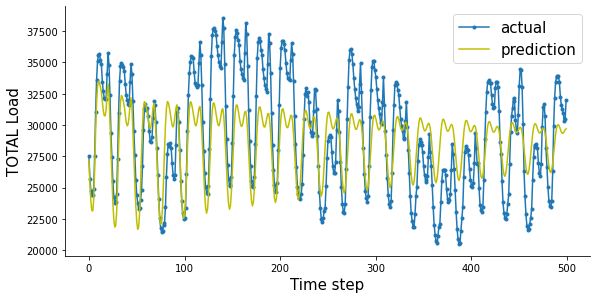

In [21]:
idx = 500
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'y', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [22]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
temp2 = df_energy.copy() # make temporary copy of dataframe

dataset1 = temp2['generation solar'].dropna().values # numpy.ndarray of the actual load
dataset1 = dataset1.astype('float32') 
dataset1 = np.reshape(dataset1, (-1, 1)) # reshape to one feature; required for the models

scaler = MinMaxScaler(feature_range=(0, 1)) # Min Max scaler
dataset1 = scaler.fit_transform(dataset1) # fit and transform the dataset

# Train and Test splits
train_size = int(len(dataset1) * 0.80) 
test_size = len(dataset1) - train_size
train, test = dataset1[0:train_size,:], dataset1[train_size:len(dataset1),:]

def create_dataset(dataset1, look_back=1):
    X, Y = [], []
    for i in range(len(dataset1)-look_back-1):
        a = dataset1[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset1[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 25 # timesteps to lookback for predictions
X_train, trainY = create_dataset(train, look_back)
X_test, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print("Shapes: \nTraining set: {}, Testing set: {}".format(X_train.shape, X_test.shape))
print("Sample from training set: \n{}".format(X_train[0]))

Shapes: 
Training set: (28010, 1, 25), Testing set: (6984, 1, 25)
Sample from training set: 
[[0.00845995 0.0086326  0.0086326  0.0086326  0.00725138 0.00587017
  0.00587017 0.00604282 0.0093232  0.12828039 0.34858426 0.5519683
  0.67075276 0.69181633 0.68594617 0.6591851  0.5331492  0.2532804
  0.06975138 0.02399862 0.01726519 0.0129489  0.01277624 0.00966851
  0.0093232 ]]


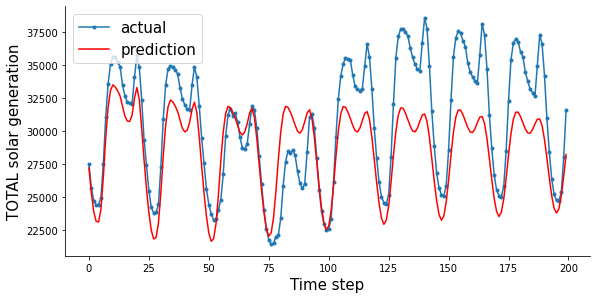

In [23]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL solar generation', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

#Linear regression Model

In [24]:
energy = pd.read_csv("energy_dataset.csv")
hour = energy.time.str.slice(11, 13)
hour.head()

0    00
1    01
2    02
3    03
4    04
Name: time, dtype: object

In [25]:
df = pd.DataFrame(energy)
df['hour'] = hour
df['time'] = pd.to_datetime(df['time'], utc=True)
df['hour'] = df['hour'].astype(str)
new_dummies = pd.get_dummies(df['hour'])

df = pd.concat([df,new_dummies],axis='columns')
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,14,15,16,17,18,19,20,21,22,23
0,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
X = ['forecast solar day ahead','forecast wind onshore day ahead', 'total load forecast','price day ahead']
y = ['price day ahead', 'price actual']

df = df.dropna(subset=X)
df = df.dropna(subset=y)

for i in df[X]:
    df[i] = pd.to_numeric(df[i])

for i in df[y]:
    df[i] = pd.to_numeric(df[i])

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df[X],df[y],test_size=0.2, random_state=0)

lr_model = LinearRegression()

lr_model.fit(X_train,y_train['price actual'])

print(lr_model.score(X_test,y_test['price actual']))
print(lr_model.score(X_train,y_train['price actual']))

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)


0.5319860398415317
0.55888332939275


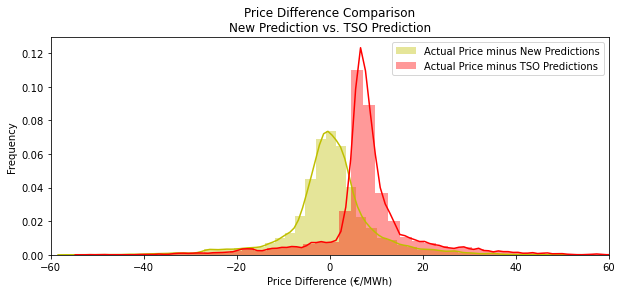

In [36]:
val_predictions = lr_model.predict(X_test)

diff1 = y_test['price actual'] - val_predictions
diff2 = y_test['price actual'] - y_test['price day ahead']

# f, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

plt.figure(figsize=(10,4))
gr = sns.distplot(diff1, bins=50, label='Actual Price minus New Predictions',color='y')
gr = sns.distplot(diff2, bins=50, label='Actual Price minus TSO Predictions',color='r')
gr.set(xlabel="Price Difference (€/MWh)", ylabel="Frequency")
gr.set_title('Price Difference Comparison\nNew Prediction vs. TSO Prediction')
gr.set(xlim=(-60,60))
plt.legend()
plt.show()

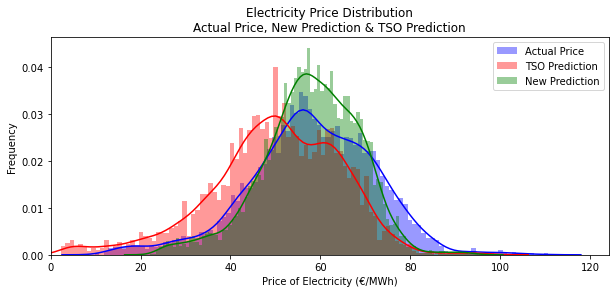

In [37]:
plt.figure(figsize=(10,4))
gr = sns.distplot(y_test['price actual'], bins=100, label='Actual Price',color='b')
gr = sns.distplot(y_test['price day ahead'], bins=100, label='TSO Prediction',color='r')
gr = sns.distplot(val_predictions, bins=100, label='New Prediction',color='g')
gr.set(xlabel="Price of Electricity (€/MWh)", ylabel="Frequency")
gr.set_title('Electricity Price Distribution\nActual Price, New Prediction & TSO Prediction')
gr.set(xlim=(0,None))
plt.legend()
plt.show()

In [41]:
rms_my_pred = sqrt(mean_squared_error(y_test['price actual'], val_predictions))
rms_TSO_pred = sqrt(mean_squared_error(
    y_test['price actual'], y_test['price day ahead']))

mean_abs_error_my_pred = mean_absolute_error(
    y_test['price actual'], val_predictions)
mean_abs_error_TSO_pred = mean_absolute_error(
    y_test['price actual'], y_test['price day ahead'])

print('Multiple Linear Regression Error: ' +
      str(rms_my_pred))
print('TSO Error: ' +
      str(rms_TSO_pred))

Multiple Linear Regression Error: 9.64588876703604
TSO Error: 13.438435236605542


In [44]:
results = pd.DataFrame({'price actual':y_test['price actual'],'New price Prediction':val_predictions,' diff b/w actual nd pred':diff1})
df1=pd.concat([df,results],axis='columns')
df1.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,17,18,19,20,21,22,23,price actual,New price Prediction,diff b/w actual nd pred
0,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
3,2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,56.04,47.363628,8.676372


In [45]:
df1.to_csv('output/linearregg.csv')